In [1]:
import lstm
import time
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import sys
import pandas as pd
from pandas import Series, DataFrame, Panel
import keras
from keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import train_test_split
import re
from datetime import datetime
from sklearn.metrics import mean_squared_error
from scipy.stats import logistic
%matplotlib inline
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Prints: [8.0, 6.0]
print ("Current size:", fig_size)
 
# Set figure width to 12 and height to 9
fig_size[0] = 24
fig_size[1] = 18
plt.rcParams["figure.figsize"] = fig_size
keras.backend.image_dim_ordering()

Using TensorFlow backend.


Current size: [6.0, 4.0]


'tf'

In [2]:
class BatchGenerator:
    
    def __init__(self, file, time_steps=48, scaler_type='standard', pca=False, pca_dim=8, normal=False):
        self.file = file
        self.time_steps = time_steps
        self.scaler_type = scaler_type
        self.pca = pca
        self.pca_dim = pca_dim
        self.normal = normal
        
        print ("Loading data ...")
        data_loaded = pd.read_pickle(self.file)
        data_loaded.isnull().sum()
        
        # load data
        data_loaded_np = data_loaded[["PM2.5","WS","RH","BP","VWS","SR","WD","TEMP"]].as_matrix()
       
        # PCA
        if self.pca == True:
            print("PCA transform")
            pca = PCA(n_components=self.pca_dim, svd_solver='full')
            pca = pca.fit(data_loaded_np)
            data_loaded_np = pca.transform(data_loaded_np)
        
        #Row Normalization    
        if self.normal == True:
            print("Normalize transform")
            self.norm_scaler = Normalizer().fit(data_loaded_np)
            data_loaded_np = self.norm_scaler.transform(data_loaded_np)

        self.X_norm_pm, self.y_norm_pm, self.scaler_pm = self.generate_batch_data(data_loaded_np[0:,0], time_steps=self.time_steps, name="pm25")
        self.X_norm_ws, self.y_norm_ws, self.scaler_ws = self.generate_batch_data(data_loaded_np[0:,1], time_steps=self.time_steps, name="ws")
        self.X_norm_rh, self.y_norm_rh, self.scaler_rh = self.generate_batch_data(data_loaded_np[0:,2], time_steps=self.time_steps, name="rh")
        self.X_norm_bp, self.y_norm_bp, self.scaler_bp = self.generate_batch_data(data_loaded_np[0:,3], time_steps=self.time_steps, name="bp")
        self.X_norm_vws, self.y_norm_vws, self.scaler_vws = self.generate_batch_data(data_loaded_np[0:,4], time_steps=self.time_steps, name="vws")
        self.X_norm_sr, self.y_norm_sr, self.scaler_sr = self.generate_batch_data(data_loaded_np[0:,5], time_steps=self.time_steps, name="sr")
        self.X_norm_wd, self.y_norm_wd, self.scaler_wd = self.generate_batch_data(data_loaded_np[0:,6], time_steps=self.time_steps, name="wd")
        self.X_norm_temp, self.y_norm_temp, self.scaler_temp = self.generate_batch_data(data_loaded_np[0:,7], time_steps=self.time_steps, name="temp")

        if not (self.scaler_type is None):
            filename = "np_"+self.scaler_type+"_process_comp_"+str(self.time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"
        else:
            filename = "np_process_comp_"+str(self.time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"

        if os.path.isfile("data_log/"+filename):
            print ("Found existing file :","data_log/"+filename)
            print ("Loading ...")
            npzfile = np.load("data_log/"+filename)
            self.X_norm_pm = npzfile['arr_0']
            self.X_norm_ws = npzfile['arr_1']
            self.X_norm_rh = npzfile['arr_2']
            self.X_norm_bp = npzfile['arr_3']
            self.X_norm_vws = npzfile['arr_4']
            self.X_norm_sr = npzfile['arr_5']
            self.X_norm_wd = npzfile['arr_6']
            self.X_norm_temp = npzfile['arr_7']
            self.Y = npzfile['arr_8']
            print ("Complete.")
        else:
            self.Y = self.y_norm_pm 
            print ("Input shape pm25:",np.shape(self.X_norm_pm))
            print ("Input shape ws:",np.shape(self.X_norm_ws))
            print ("Input shape rh:",np.shape(self.X_norm_rh))
            print ("Input shape bp:",np.shape(self.X_norm_bp))
            print ("Input shape vws:",np.shape(self.X_norm_vws))
            print ("Input shape sr:",np.shape(self.X_norm_sr))
            print ("Input shape wd:",np.shape(self.X_norm_wd))
            print ("Input shape temp:",np.shape(self.X_norm_temp))
            print ("Output shape :",np.shape(self.Y))
            print ("Saving file ...")
            np.savez("data_log/"+filename, self.X_norm_pm, self.X_norm_ws, self.X_norm_rh, self.X_norm_bp, self.X_norm_vws, self.X_norm_sr, self.X_norm_wd, self.X_norm_temp, self.Y)
            print ("Saved file to :", filename)
            print ("Complete.")
        
    def return_data(self):
        return self.X_norm_pm, self.X_norm_ws, self.X_norm_rh, self.X_norm_bp, self.X_norm_vws, self.X_norm_sr, self.X_norm_wd, self.X_norm_temp, self.Y, self.scaler_pm

    def shift(self, arr, num, fill_value=np.nan):
        result = np.empty_like(arr)
        if num > 0:
            result[:num] = fill_value
            result[num:] = arr[:-num]
        elif num < 0:
            result[num:] = fill_value
            result[:num] = arr[-num:]
        else:
            result = arr
        return result

    def generate_batch_data(self, raw_data, time_steps, name):
        series = pd.Series(raw_data, dtype=np.float32)
        values = series.values
        values = values.reshape((len(values), 1))
        print('feature ------------ ', name.upper())
        
        if self.scaler_type == 'standard':
            scaler = StandardScaler()
        if self.scaler_type == 'robust':
            scaler = RobustScaler()
        if self.scaler_type == 'min_max':
            scaler = MinMaxScaler(feature_range=(0, 1))
            
        scaler = scaler.fit(values)
        normalized = scaler.transform(values)
        
        #data = values
        data = normalized
        print('Max: %f, Min: %f' % (np.amax(data), np.amin(data)))
        x = data[:(len(data)-(len(data) % time_steps))]
        y = self.shift(data,-(time_steps)).astype(np.float32)

        x_batches = np.array([])
        y_batches = np.array([])

        # check if file exists
        if (self.scaler_type is None):
            seq_file_name = "np_processed_"+name+"_"+str(time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"
        else:
            seq_file_name = "np_"+self.scaler_type+"_processed_"+name+"_"+str(time_steps)+"_"+str(self.pca)+"_"+str(self.normal)+".npz"          

        if os.path.isfile("data_log/"+seq_file_name):
            npzfile = np.load("data_log/"+seq_file_name)
            x_batches = npzfile['arr_0']
            y_batches = npzfile['arr_1']
            return x_batches, y_batches, scaler
        else: 
            for i in range(len(y)):
                try:
                    x_batches = np.append(x_batches, x[i:i+(time_steps)].reshape(-1,12,1))
                    y_batches = np.append(y_batches, y[i].reshape(-1))
                except ValueError:
                    break
                    
            x_batches = x_batches.reshape(-1, time_steps, 1)
            y_batches = y_batches.reshape(-1)
            np.savez("data_log/"+seq_file_name, x_batches, y_batches)
            return x_batches, y_batches, scaler

In [3]:
if __name__=='__main__':
    global_start_time = time.time()
    startTime = datetime.now() 
    epochs  = 150
    state_neurons_1 = 64
    state_neurons_2 = 64
    state_neurons_3 = 64
    output = 1
    seed = 7
    batch_size = 32
    scaler_type="standard"
    dropouts = [0.15, 0.25, 0.45]
    seq_len = 48
    
    
    batch_generator_obj = BatchGenerator(file="data_log/mumbai_6_log_pro.pkl", time_steps=48, scaler_type=scaler_type, pca=False, pca_dim=8, normal=False)
    X_norm_pm, X_norm_ws, X_norm_rh, X_norm_bp, X_norm_vws, X_norm_sr, X_norm_wd, X_norm_temp, y_norm, scaler = batch_generator_obj.return_data()
    
    X_train_pm, X_val_pm, X_train_ws, X_val_ws, X_train_rh, X_val_rh, X_train_bp, X_val_bp, X_train_vws, X_val_vws, X_train_sr, X_val_sr, X_train_wd, X_val_wd, X_train_temp, X_val_temp, y_train, y_val = train_test_split(X_norm_pm, X_norm_ws, X_norm_rh, X_norm_bp, X_norm_vws, X_norm_sr, X_norm_wd, X_norm_temp, y_norm, test_size=0.20, random_state=seed)
    
    print('> Data Loaded. Compiling...')
    model = lstm.build_model([4, 7], [7, seq_len, state_neurons_1, state_neurons_2, output], dropouts)
    
    file_name = "wt_LSTM_Keras_tanh_rmsprop_"+scaler_type+"_dp("+"_".join(str(x) for x in dropouts)+")_"+str(epochs)+"_"+str(seq_len)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(batch_size)
    checkpoint = ModelCheckpoint(file_name+".h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]

    mod_hist = model.fit([X_train_pm, X_train_ws, X_train_rh, X_train_bp, X_train_vws, X_train_sr, X_train_wd, X_train_temp], [y_train], validation_data=([X_val_pm, X_val_ws, X_val_rh, X_val_bp, X_val_vws, X_val_sr, X_val_wd, X_val_temp], [y_val]), epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)

    print('Training duration (s) : ', time.time() - global_start_time)
    print('Training duration (Hr) : ', datetime.now() - startTime)
    
    file = "LSTM_Keras_linear_rmsprop_"+scaler_type+"_dp("+"_".join(str(x) for x in dropouts)+")_"+str(epochs)+"_"+str(seq_len)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(state_neurons_1)+"_"+str(batch_size)
    print("Saving model : "+file+".h5")
    model.save(file+".h5")
    print("Model saved...")

Loading data ...
feature ------------  PM25
Max: 3.284291, Min: -10.752898
feature ------------  WS
Max: 3.415116, Min: -2.449860
feature ------------  RH
Max: 1.363076, Min: -4.063657
feature ------------  BP
Max: 5.360242, Min: -7.499539
feature ------------  VWS
Max: 9.401879, Min: -11.963299
feature ------------  SR
Max: 1.637784, Min: -2.654759
feature ------------  WD
Max: 1.076242, Min: -6.484889
feature ------------  TEMP
Max: 3.006956, Min: -3.982146
Found existing file : data_log/np_standard_process_comp_48_False_False.npz
Loading ...
Complete.
> Data Loaded. Compiling...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputL

15706/15706 [==============================] - ETA: 0s - loss: 0.7434 - val_loss: 0.8891
Epoch 2/150
15706/15706 [==============================] - ETA: 0s - loss: 0.6283 - val_loss: 0.6625
Epoch 3/150
15706/15706 [==============================] - ETA: 0s - loss: 0.5999 - val_loss: 0.6806
Epoch 4/150
15706/15706 [==============================] - ETA: 0s - loss: 0.6200 - val_loss: 0.6109
Epoch 5/150
15706/15706 [==============================] - ETA: 0s - loss: 0.5597 - val_loss: 0.4880
Epoch 6/150
15706/15706 [==============================] - ETA: 0s - loss: 0.5156 - val_loss: 0.4738
Epoch 7/150
15706/15706 [==============================] - ETA: 0s - loss: 0.4801 - val_loss: 0.4634
Epoch 8/150
15706/15706 [==============================] - ETA: 0s - loss: 0.4536 - val_loss: 0.4281
Epoch 9/150
15706/15706 [==============================] - ETA: 0s - loss: 0.4314 - val_loss: 0.4758
Epoch 10/150
15706/15706 [==============================] - ETA: 0s - loss: 0.4200 - val_loss: 0.4047
E

15706/15706 [==============================] - ETA: 0s - loss: 0.2868 - val_loss: 0.2824
Epoch 33/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2884 - val_loss: 0.2827
Epoch 34/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2874 - val_loss: 0.2626
Epoch 35/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2863 - val_loss: 0.3310
Epoch 36/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2868 - val_loss: 0.2805
Epoch 37/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2849 - val_loss: 0.2914
Epoch 38/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2843 - val_loss: 0.3020
Epoch 39/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2822 - val_loss: 0.2710
Epoch 40/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2872 - val_loss: 0.2763
Epoch 41/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2832 - val_loss: 

Epoch 71/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2616 - val_loss: 0.2693
Epoch 72/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2616 - val_loss: 0.2766
Epoch 73/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2584 - val_loss: 0.3051
Epoch 74/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2585 - val_loss: 0.2750
Epoch 75/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2598 - val_loss: 0.2811
Epoch 76/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2575 - val_loss: 0.2698
Epoch 77/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2566 - val_loss: 0.2828
Epoch 78/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2605 - val_loss: 0.3236
Epoch 79/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2587 - val_loss: 0.3002
Epoch 80/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2566

15706/15706 [==============================] - ETA: 0s - loss: 0.2297 - val_loss: 0.3001
Epoch 111/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2320 - val_loss: 0.3016
Epoch 112/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2311 - val_loss: 0.3074
Epoch 113/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2277 - val_loss: 0.3042
Epoch 114/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2265 - val_loss: 0.2861
Epoch 115/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2319 - val_loss: 0.2876
Epoch 116/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2274 - val_loss: 0.2923
Epoch 117/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2277 - val_loss: 0.3023
Epoch 118/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2272 - val_loss: 0.2905
Epoch 119/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2244 - v

15706/15706 [==============================] - ETA: 0s - loss: 0.2114 - val_loss: 0.3046
Epoch 150/150
15706/15706 [==============================] - ETA: 0s - loss: 0.2074 - val_loss: 0.3068
Training duration (s) :  13217.998766422272
Training duration (Hr) :  3:40:17.999234
Saving model : LSTM_Keras_linear_rmsprop_standard_dp(0.15_0.25_0.45)_150_48_64_64_64_32.h5
Model saved...


In [4]:
if __name__=='__main__':
    #predict sequence
    _y_norm = lstm.predict_point_by_point_aux(model, [X_norm_pm, X_norm_ws, X_norm_rh, X_norm_bp, X_norm_vws, X_norm_sr, X_norm_wd, X_norm_temp])
    _y_train = lstm.predict_point_by_point_aux(model, [X_train_pm, X_train_ws, X_train_rh, X_train_bp, X_train_vws, X_train_sr, X_train_wd, X_train_temp])
    _y_val = lstm.predict_point_by_point_aux(model, [X_val_pm, X_val_ws, X_val_rh, X_val_bp, X_val_vws, X_val_sr, X_val_wd, X_val_temp])


In [5]:
if __name__=='__main__':
    _y_norm = _y_norm.reshape(-1,1)
    _y_train = _y_train.reshape(-1,1)
    _y_val = _y_val.reshape(-1,1)
    
    y_norm = y_norm.reshape(-1,1)
    y_train = y_train.reshape(-1,1)
    y_val = y_val.reshape(-1,1)
    
    print("Predicted Output shape: ", np.shape(_y_norm))
    print("Original Output shape:  ", np.shape(y_norm))
    
    #inverse the predictions to its actual value
    print("Predicted Output sample: ")
    _y = scaler.inverse_transform(_y_norm)
    _y_tr = scaler.inverse_transform(_y_train)
    _y_va = scaler.inverse_transform(_y_val)
    for i in range(5):
        print(_y_va[i])
    
    #inverse the outputs to its actual value
    print("Original Output sample: ")
    y = scaler.inverse_transform(y_norm)
    y_tr = scaler.inverse_transform(y_train)
    y_va = scaler.inverse_transform(y_val)
    for i in range(5):
        print(y_va[i])    
    
    #predicted
    _Y = pd.Series(np.ravel(_y))
    _Y_TR = pd.Series(np.ravel(_y_tr))
    _Y_VA = pd.Series(np.ravel(_y_va))
#     _Y_TE = pd.Series(np.ravel(_y_te))
    
    #original
    Y =  pd.Series(np.ravel(y))
    Y_TR = pd.Series(np.ravel(y_tr))
    Y_VA = pd.Series(np.ravel(y_va))
#     Y_TE = pd.Series(np.ravel(y_te))

Predicted Output shape:  (19633, 1)
Original Output shape:   (19633, 1)
Predicted Output sample: 
[ 3.5228436]
[ 2.0591197]
[ 2.12234712]
[ 3.94902802]
[ 4.3932929]
Original Output sample: 
[ 3.09013296]
[ 2.12106327]
[ 1.01884742]
[ 4.13180111]
[ 4.21641493]


Total RMSE : 0.33968386233691766
Training RMSE : 0.3154989248033917
Validation RMSE : 0.4227993323035585


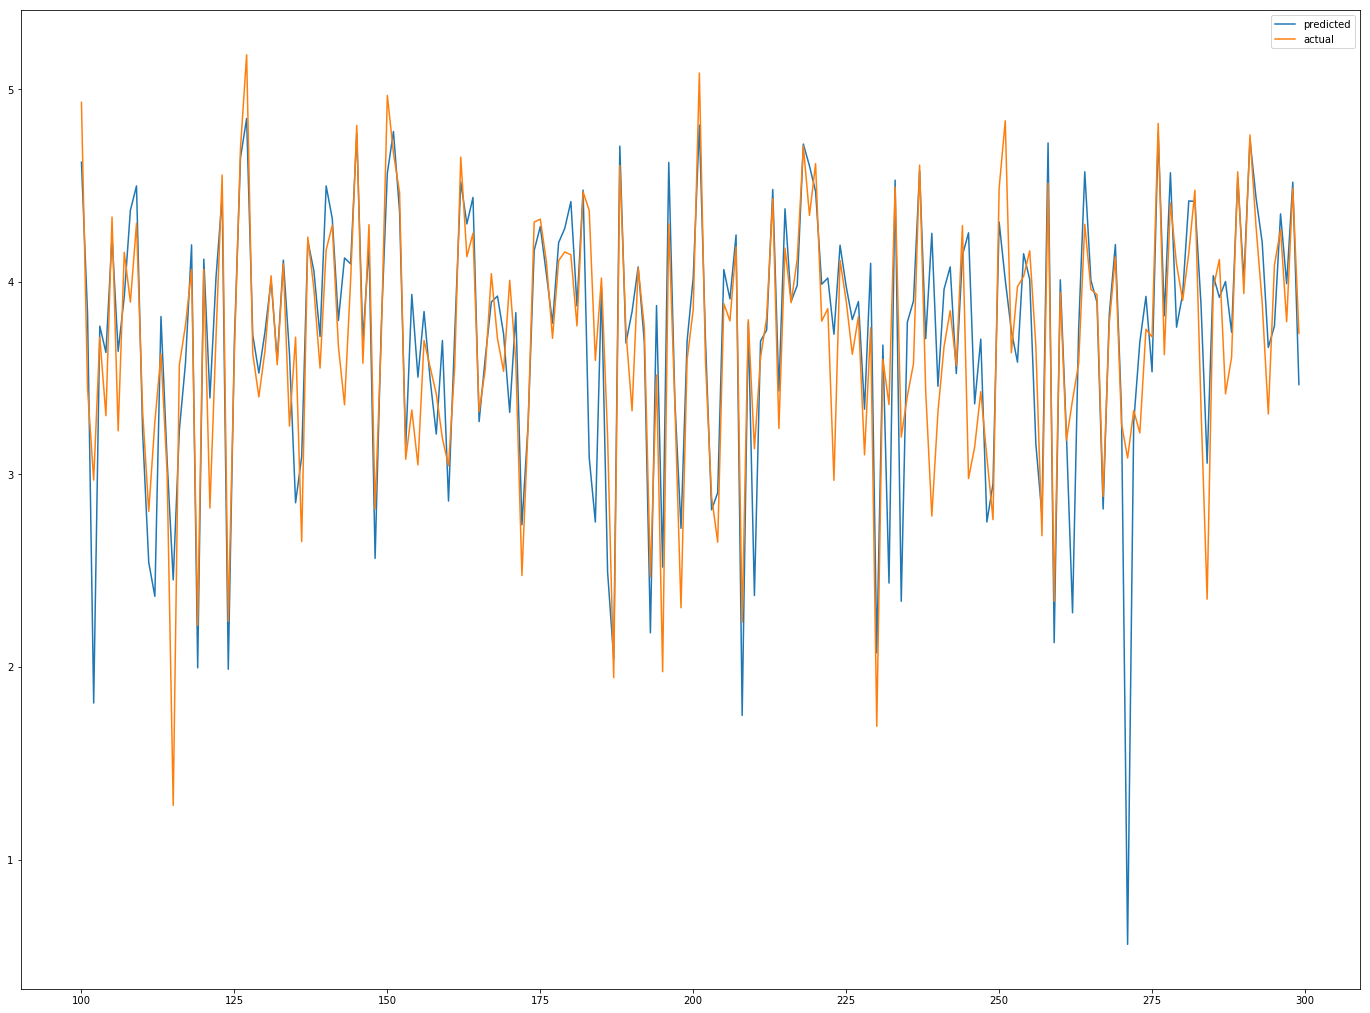

In [6]:
if __name__=='__main__':
    print('Total RMSE :', math.sqrt(mean_squared_error(_Y, Y)))
    print('Training RMSE :', math.sqrt(mean_squared_error(_Y_TR, Y_TR)))
    print('Validation RMSE :', math.sqrt(mean_squared_error(_Y_VA, Y_VA)))
#     print('Test RMSE :', math.sqrt(mean_squared_error(_Y_TE, Y_TE)))
    
    plot_predicted, = plt.plot(_Y_VA[100:300], label='predicted')
    plot_train, = plt.plot(Y_VA[100:300], label='actual')
    plt.legend(handles=[plot_predicted, plot_train])

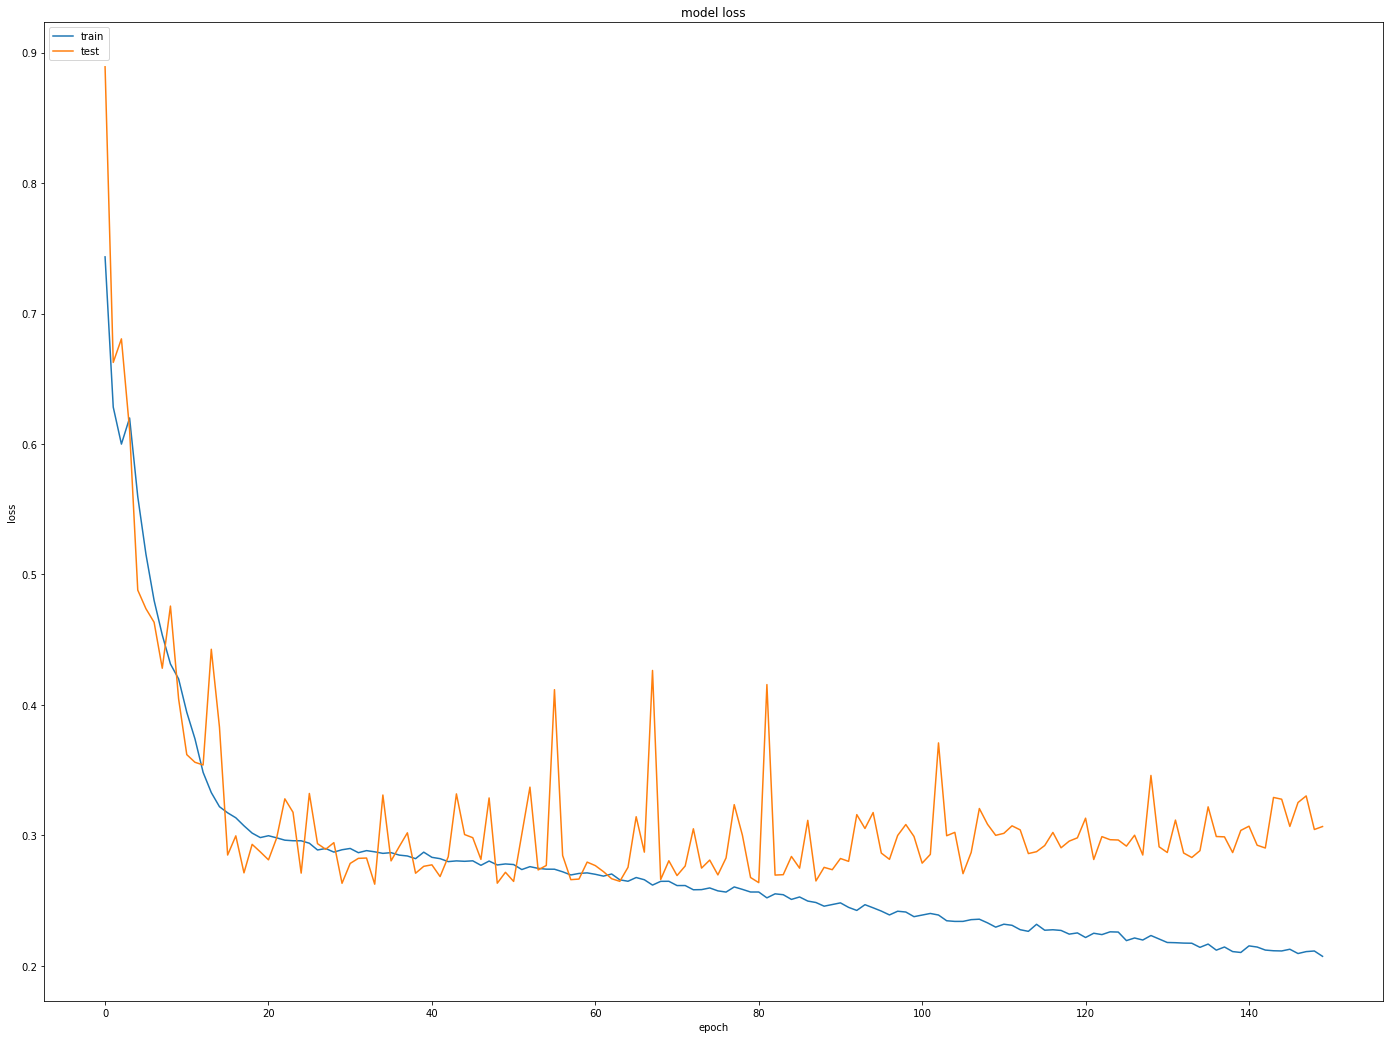

In [7]:
# summarize history for loss
plt.plot(mod_hist.history['loss'])
plt.plot(mod_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 48, 1)        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 48, 1)        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, 48, 1)        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 48, 1)        0                                            
__________________________________________________________________________________________________
input_13 (

Predicted Output sample: 
[ 3.25087237]
[ 2.29531717]
[ 2.70969915]
[ 4.17390728]
[ 4.5142312]
Original Output sample: 
[ 3.09013296]
[ 2.12106327]
[ 1.01884742]
[ 4.13180111]
[ 4.21641493]
Validation RMSE : 18.573129877855372


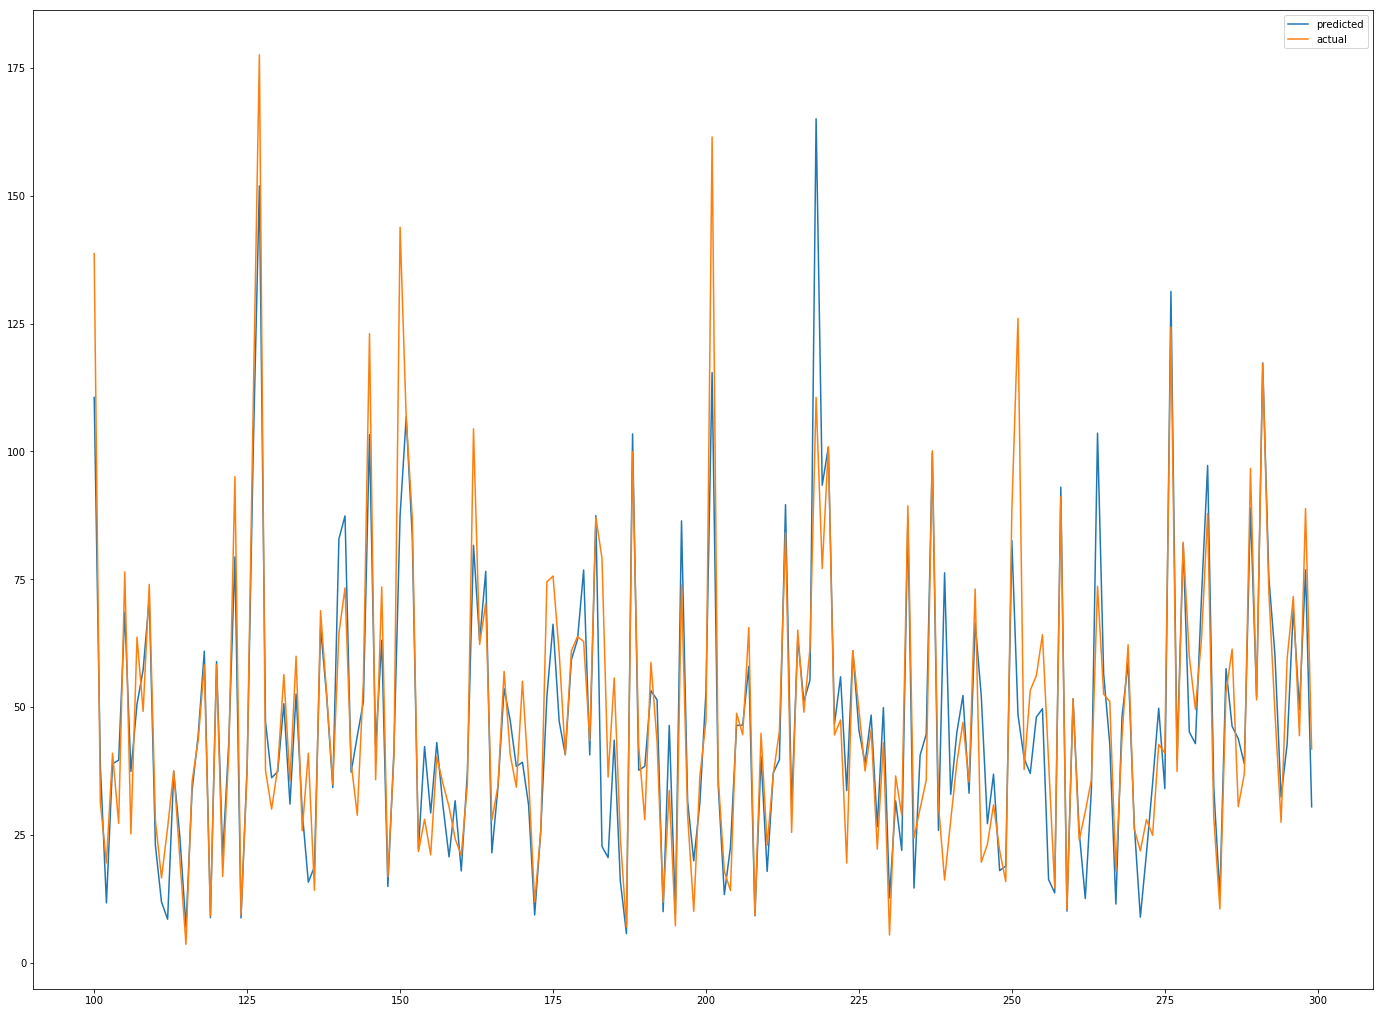

In [8]:
if __name__=='__main__':
    #recreate model 
    model = lstm.build_model([4, 7], [7, seq_len, state_neurons_1, state_neurons_2, output], dropouts, pre_train=file_name+".h5")
    print("Created model and loaded weights from "+file_name+".h5")
    
    # estimate accuracy on whole dataset using loaded weights
    _y_val = lstm.predict_point_by_point_aux(model, [X_val_pm, X_val_ws, X_val_rh, X_val_bp, X_val_vws, X_val_sr, X_val_wd, X_val_temp])
    
    _y_val = _y_val.reshape(-1,1)
    
    y_val = y_val.reshape(-1,1)
    
    #inverse the predictions to its actual value
    print("Predicted Output sample: ")
    _y_va = scaler.inverse_transform(_y_val)
    for i in range(5):
        print(_y_va[i])
    
    #inverse the outputs to its actual value
    print("Original Output sample: ")
    y_va = scaler.inverse_transform(y_val)
    for i in range(5):
        print(y_va[i])    
    
    
    y_va = np.exp(y_va)
    _y_va = np.exp(_y_va)
    
    #predicted
    _Y_VA = pd.Series(np.ravel(_y_va))
    
    #original
    Y_VA = pd.Series(np.ravel(y_va))
    
    print('Validation RMSE :', math.sqrt(mean_squared_error(_Y_VA, Y_VA)))
    
    plot_predicted, = plt.plot(_Y_VA[100:300], label='predicted')
    plot_train, = plt.plot(Y_VA[100:300], label='actual')
    plt.legend(handles=[plot_predicted, plot_train])

In [9]:
def squash(x):
    return float(1.0 * x/(x+10))